In [44]:
import pandas as pd
import numpy as np

In [45]:
train = pd.read_csv('/content/kannada_offensive_train.tsv', error_bad_lines=False, sep="\t", header=None)
test= pd.read_csv('/content/kannada_offensive_dev.tsv', error_bad_lines=False, sep="\t", header=None)
print(train)
print(test)

                                                      0                                     1
0     Tik tok alli jagala madtidralla adra baggenu o...                         Not_offensive
1                               Anyone from kerala here                           not-Kannada
2                             Movie rerelease madi plss                         Not_offensive
3     Amazon prime alli bittidira....yella manele no...                         Not_offensive
4     Guru sure news nanu tik tok dawn lod madeda ya...                         Not_offensive
...                                                 ...                                   ...
6212                @Gajendra hv neen en maadirodu mele  Offensive_Targeted_Insult_Individual
6213                       Sir neev adthidda game yavdu                         Not_offensive
6214                          Dubb Full movie in telugu                         Not_offensive
6215  Mostly nimma mate keli tic tok ban agirbeku ಅಣ...     

In [46]:
df=train.filter([1,0], axis=1)
df_test=test.filter([1,0],axis=1)

In [47]:
df[1].value_counts()

Not_offensive                           3544
not-Kannada                             1522
Offensive_Targeted_Insult_Individual     487
Offensive_Targeted_Insult_Group          329
Offensive_Untargetede                    212
Offensive_Targeted_Insult_Other          123
Name: 1, dtype: int64

In [48]:
#removing @ and #
def punc(df):
    df[0] = df[0].str.replace('[#@()]','')
    df[0]=df[0].str.replace('[^\w\s]','')
    print(df)

In [49]:
punc(df)
punc(df_test)

                                         1                                                  0
0                            Not_offensive  Tik tok alli jagala madtidralla adra baggenu o...
1                              not-Kannada                            Anyone from kerala here
2                            Not_offensive                          Movie rerelease madi plss
3                            Not_offensive    Amazon prime alli bittidirayella manele nodtare
4                            Not_offensive  Guru sure news nanu tik tok dawn lod madeda ya...
...                                    ...                                                ...
6212  Offensive_Targeted_Insult_Individual                 Gajendra hv neen en maadirodu mele
6213                         Not_offensive                       Sir neev adthidda game yavdu
6214                         Not_offensive                          Dubb Full movie in telugu
6215                         Not_offensive  Mostly nimma mat

In [50]:
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
import io
import os

In [51]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df, valid_df = df_test, path = "")

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [52]:
data_lm.show_batch

<bound method DataBunch.show_batch of TextLMDataBunch;

Train: LabelList (6217 items)
x: LMTextList
xxbos xxmaj tik tok alli jagala xxunk adra xxunk ondu video madi anna super agi xxunk,xxbos xxmaj anyone from kerala here,xxbos xxmaj movie rerelease madi plss,xxbos xxmaj amazon prime alli xxunk manele nodtare,xxbos xxmaj guru sure news nanu tik tok xxunk xxunk xxunk yavaga nama xxunk tindu nama xxunk xxunk xxunk xxunk xxunk avaga xxunk
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (777 items)
x: LMTextList
xxbos 100 days pakka,xxbos xxmaj super sir,xxbos xxmaj hands up,xxbos xxmaj sari nivu video na roast madi adre xxunk pubg xxunk free fire games xxunk madbedi a games kooda xxmaj chinese,xxbos xxmaj xxunk shapa xxunk
y: LMLabelList
,,,,
Path: .;

Test: None>

In [53]:
#loading AWD_LSTM language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.97E-02
Min loss divided by 10: 5.22E-03


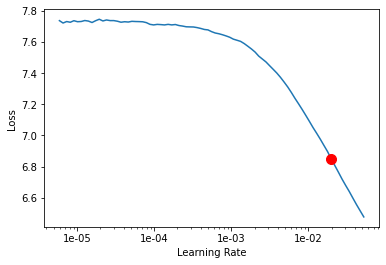

In [54]:
learn.lr_find(start_lr=2e-6, end_lr=1e-1)
learn.recorder.plot(suggestion = True)

In [55]:
#fitting the data
learn.fit_one_cycle(2, 5e-2)
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,6.250430,4.626724,0.314174,00:02
1,5.377057,4.454918,0.326786,00:02


In [56]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.797124,4.517086,0.295982,00:03
1,4.515275,4.172214,0.352121,00:03
2,4.126434,4.186436,0.350112,00:03


In [57]:
learn.freeze_to(-1)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.20E-02


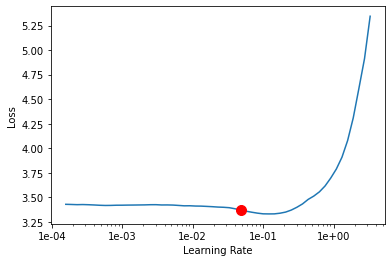

In [58]:
learn.recorder.plot(skip_start=40, suggestion=True)

In [59]:
learn.fit_one_cycle(3, slice(2e-2/(2.6**4), 2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.531640,4.167752,0.349665,00:02
1,3.324444,4.197456,0.351897,00:02
2,3.097304,4.198095,0.345982,00:02


In [60]:
learn.freeze_to(-2)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-03
Min loss divided by 10: 1.32E-03


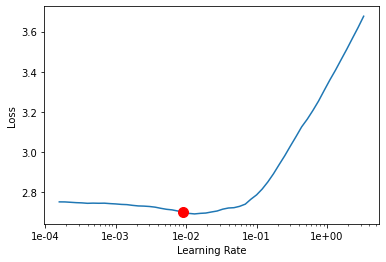

In [61]:
learn.recorder.plot(skip_start=40, suggestion=True)

In [62]:
learn.fit_one_cycle(3, slice(6e-3/(2.6**4), 6e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.754373,4.282392,0.345424,00:02
1,2.644120,4.379873,0.340513,00:02
2,2.528914,4.383821,0.334375,00:02


In [63]:
#save the encoder model
learn.save_encoder('my_encoder')

In [64]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [65]:
#building classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])

#loading the saved encoder
learn.load_encoder('my_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6217 items)
x: TextList
xxbos xxmaj tik tok alli jagala xxunk adra xxunk ondu video madi anna super agi xxunk,xxbos xxmaj anyone from kerala here,xxbos xxmaj movie rerelease madi plss,xxbos xxmaj amazon prime alli xxunk manele nodtare,xxbos xxmaj guru sure news nanu tik tok xxunk xxunk xxunk yavaga nama xxunk tindu nama xxunk xxunk xxunk xxunk xxunk avaga xxunk
y: CategoryList
Not_offensive,not-Kannada,Not_offensive,Not_offensive,Not_offensive
Path: .;

Valid: LabelList (777 items)
x: TextList
xxbos 100 days pakka,xxbos xxmaj super sir,xxbos xxmaj hands up,xxbos xxmaj sari nivu video na roast madi adre xxunk pubg xxunk free fire games xxunk madbedi a games kooda xxmaj chinese,xxbos xxmaj xxunk shapa xxunk
y: CategoryList
Not_offensive,not-Kannada,not-Kannada,Not_offensive,Not_offensive
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(4344, 400, padding_idx=1)
   

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 5.25E-02


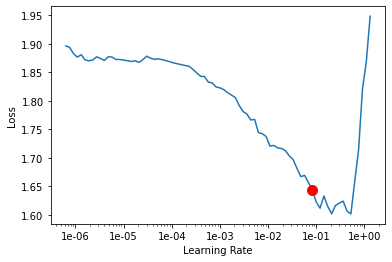

In [66]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [67]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.118035,0.979858,0.635779,0.311177,00:03
1,0.979299,0.921477,0.669241,0.000000,00:03
2,0.913406,0.913978,0.687259,0.000000,00:02


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

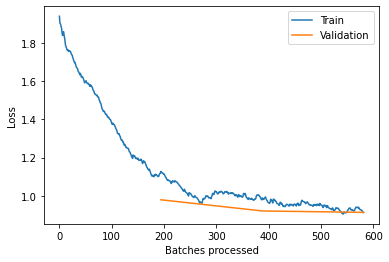

In [68]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 5.75E-07


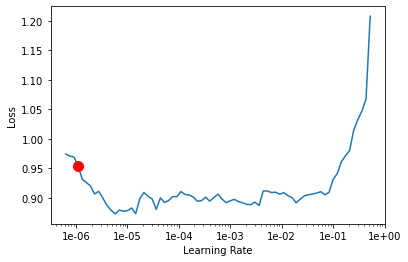

In [69]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [70]:
learn.freeze_to(-2) # unfreeze last 2 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.947154,0.903032,0.658945,0.316728,00:03
1,0.859886,0.871040,0.674389,0.000000,00:03


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 9.12E-08


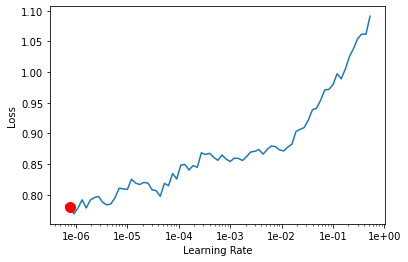

In [71]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [72]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5.3e-3/(2.6**4),5.31e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.868949,0.850459,0.700129,0.351836,00:05
1,0.756091,0.863527,0.696268,0.000000,00:05


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

In [73]:
learn.freeze_to(-4) # unfreeze last 4 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.freeze_to(-5) # unfreeze last 5 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

# Unfreezing all the layers and training
learn.unfreeze() # unfreze all
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.781549,0.882288,0.701416,0.387804,00:06
1,0.614464,0.909498,0.700129,0.453674,00:06


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.622420,0.941317,0.679537,0.389302,00:06
1,0.463116,0.947652,0.684685,0.417823,00:07


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.410109,0.972311,0.691120,0.411207,00:07
1,0.376456,0.997727,0.692407,0.421847,00:07
2,0.332173,1.007288,0.685972,0.421302,00:07


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

In [75]:
#getting the predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

In [76]:
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5
row_0,,,,,,
0,336,26,19,10,21,40
1,13,10,2,3,2,1
2,11,4,35,1,3,0
3,3,1,1,0,0,1
4,3,3,2,0,3,0
5,60,1,7,2,4,149


In [77]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
cm=confusion_matrix(predictions,targets)
print(cm)
score = accuracy_score( predictions, targets)
print(score)

[[336  26  19  10  21  40]
 [ 13  10   2   3   2   1]
 [ 11   4  35   1   3   0]
 [  3   1   1   0   0   1]
 [  3   3   2   0   3   0]
 [ 60   1   7   2   4 149]]
0.685971685971686


In [78]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,targets, zero_division=0))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       452
           1       0.22      0.32      0.26        31
           2       0.53      0.65      0.58        54
           3       0.00      0.00      0.00         6
           4       0.09      0.27      0.14        11
           5       0.78      0.67      0.72       223

    accuracy                           0.69       777
   macro avg       0.40      0.44      0.41       777
weighted avg       0.73      0.69      0.70       777

